# Data loading functions

In [1]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def resize_image_by_ratio(image_path, ratio):
    # Open the image file
    original_image = Image.open(image_path)

    # Get the original dimensions
    original_width, original_height = original_image.size
    # Calculate the new dimensions based on the ratio
    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)

    # Resize the image
    resized_image = original_image.resize((new_width, new_height))

    return resized_image

def load_image_data(data_path, classes, ratio=0.5):

    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0 or elt.find('.tiff') > 0]
        for img in tqdm(images_path):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = resize_image_by_ratio(path, ratio)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)
    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    ### Normalizing pixels' intensities
    X_train = X_train / 255.
    X_val = X_val / 255.
    X_test = X_test / 255.

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes


2023-11-30 09:10:45.314715: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 09:10:45.349849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 09:10:45.603597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 09:10:45.605571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 09:10:46.587030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2023-11-29 22:33:37.641130: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 22:33:37.689442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 22:33:37.958726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 22:33:37.960277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 22:33:39.231514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  0


2023-11-29 22:33:43.631671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 22:33:43.631930: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Step-1 Load images

Get X and y

In [3]:
data_path = "/home/xiao/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/species"
classes = {'Falciparum':0, 'Malariae':1, 'Ovale':2, 'Vivax':3}
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_image_data(data_path, classes,ratio=0.5)


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


In [15]:
input_shape = X_train[0].shape
input_shape


(972, 1296, 3)

In [ ]:
X_train[0]


/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


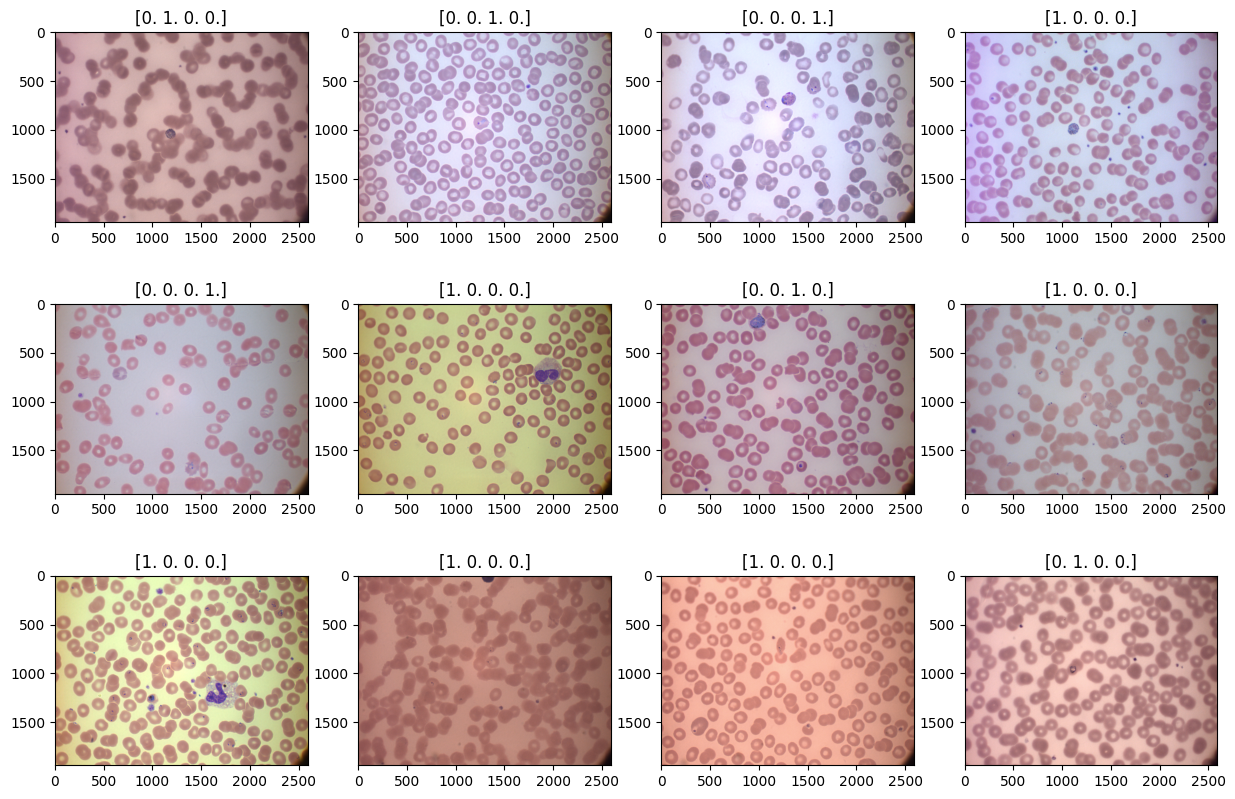

In [6]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3,4, i+1)
    img = X_train[i]
    label = y_train[i]
    plt.imshow(img)
    plt.title(label)


# Functions to train_model and dispplay result

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
def train_model(model):
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=15,  # Limiting to 5 epochs as per the instructions
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )
    return history, early_stopping


In [6]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)


# Baseline score

In [16]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

def calculate_baseline_metrics(true_labels):
    # Identify the majority class
    majority_class = tf.math.argmax(tf.math.bincount(true_labels))

    # Create predictions always predicting the majority class
    predicted_labels = tf.fill(tf.shape(true_labels), majority_class)

    # Convert to NumPy arrays
    true_labels_np = true_labels.numpy()
    predicted_labels_np = predicted_labels.numpy()

    # Calculate baseline metrics using confusion matrix
    cm = confusion_matrix(true_labels_np, predicted_labels_np)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    baseline_accuracy = tf.metrics.Accuracy()(true_labels, predicted_labels)
    baseline_precision = tf.metrics.Precision()(true_labels, predicted_labels)
    baseline_recall = tf.metrics.Recall()(true_labels, predicted_labels)
    baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall)

    return baseline_accuracy, baseline_precision, baseline_recall, baseline_f1


# Example true labels (replace with your actual labels)
y = []
true_labels = y_train

    # Calculate baseline metrics
    baseline_accuracy, baseline_precision, baseline_recall, baseline_f1 = calculate_baseline_metrics(true_labels)

    # Print baseline metrics
    print("Baseline Accuracy:", baseline_accuracy.numpy())
    print("Baseline Precision:", baseline_precision.numpy())
    print("Baseline Recall:", baseline_recall.numpy())
    print("Baseline F1 Score:", baseline_f1.numpy())


Epoch 1/15


ValueError: in user code:

    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/xiao/.pyenv/versions/3.8.12/envs/malaria_classification/lib/python3.8/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 972, 1296, 4) are incompatible


# Model-1 LeNet-5

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Rescaling, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
input_shape = X_train[0].shape
def lenet_5():
    cnn1 = models.Sequential([
        Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Conv2D(16, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn1


Epoch 1/15
9/9 [==============================] - 11s 1s/step - loss: 65.5645 - accuracy: 0.3383 - val_loss: 10.3599 - val_accuracy: 0.5000
Epoch 2/15
9/9 [==============================] - 8s 934ms/step - loss: 4.0630 - accuracy: 0.3609 - val_loss: 1.1468 - val_accuracy: 0.5000
Epoch 3/15
9/9 [==============================] - 8s 936ms/step - loss: 1.1555 - accuracy: 0.4812 - val_loss: 1.1053 - val_accuracy: 0.5000
Epoch 4/15
9/9 [==============================] - 8s 919ms/step - loss: 1.1837 - accuracy: 0.5113 - val_loss: 1.0228 - val_accuracy: 0.5000
Epoch 5/15
9/9 [==============================] - 8s 926ms/step - loss: 1.1799 - accuracy: 0.5489 - val_loss: 1.0958 - val_accuracy: 0.5952
Epoch 6/15
9/9 [==============================] - 8s 918ms/step - loss: 1.1667 - accuracy: 0.5263 - val_loss: 1.1368 - val_accuracy: 0.5000
Epoch 7/15
9/9 [==============================] - 9s 955ms/step - loss: 1.1849 - accuracy: 0.5188 - val_loss: 1.0555 - val_accuracy: 0.6190
Best Weights: [array

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

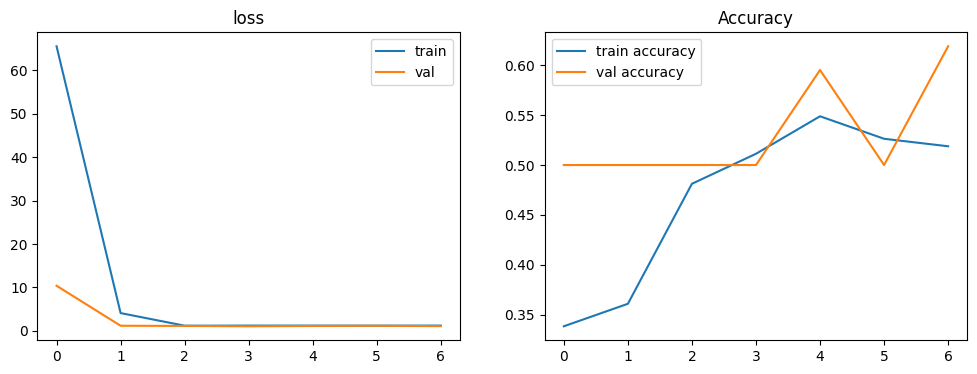

In [8]:
# Plot training history
model = lenet_5()
history, early_stopping = train_model(model)
# Access the best weights
best_weights = model.get_weights()

# Access other information such as the best epoch
best_epoch = early_stopping.stopped_epoch

# Print or use the best weights and other information as needed
print("Best Weights:", best_weights)
print("Best Epoch:", best_epoch)
plot_history(history)


In [ ]:
from tensorflow.keras import layers, models
# Load the saved model
loaded_model = models.load_model('/home/jupyter/trained_model')


# Make predictions
predictions = loaded_model.predict(X_test)


# Model 

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def cnn():
    # Create a simple CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Epoch 1/15
9/9 [==============================] - 40s 4s/step - loss: 11.1664 - accuracy: 0.3609 - val_loss: 1.1635 - val_accuracy: 0.5000
Epoch 2/15
9/9 [==============================] - 37s 4s/step - loss: 1.0612 - accuracy: 0.5038 - val_loss: 0.7661 - val_accuracy: 0.6429
Epoch 3/15
9/9 [==============================] - 38s 4s/step - loss: 0.8655 - accuracy: 0.6316 - val_loss: 0.8558 - val_accuracy: 0.5952
Epoch 4/15
9/9 [==============================] - 38s 4s/step - loss: 0.8062 - accuracy: 0.6316 - val_loss: 0.6727 - val_accuracy: 0.6190
Epoch 5/15
9/9 [==============================] - 39s 4s/step - loss: 0.7447 - accuracy: 0.5940 - val_loss: 0.5466 - val_accuracy: 0.7381
Epoch 6/15
9/9 [==============================] - 37s 4s/step - loss: 0.5781 - accuracy: 0.7519 - val_loss: 0.3737 - val_accuracy: 0.8571
Epoch 7/15
9/9 [==============================] - 38s 4s/step - loss: 0.5100 - accuracy: 0.8346 - val_loss: 0.5670 - val_accuracy: 0.8095
Epoch 8/15
9/9 [=================

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

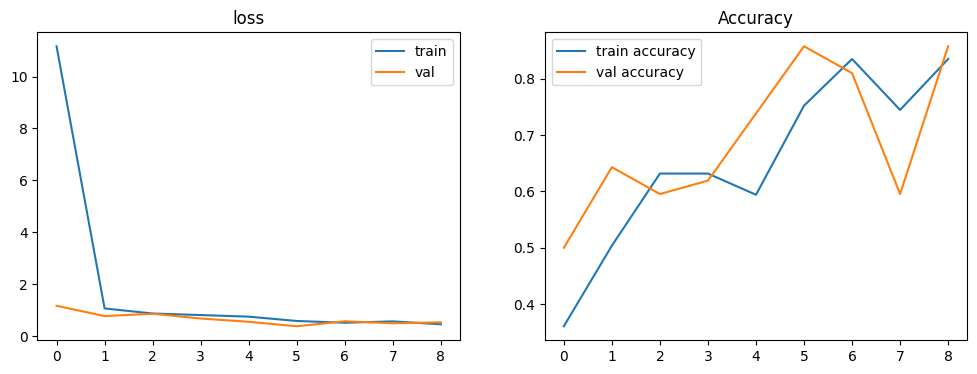

In [18]:
model = cnn()
history, early_stopping = train_model(model)
# Access the best weights
best_weights = model.get_weights()

# Access other information such as the best epoch
best_epoch = early_stopping.stopped_epoch

# Print or use the best weights and other information as needed
print("Best Weights:", best_weights)
print("Best Epoch:", best_epoch)
plot_history(history)


(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

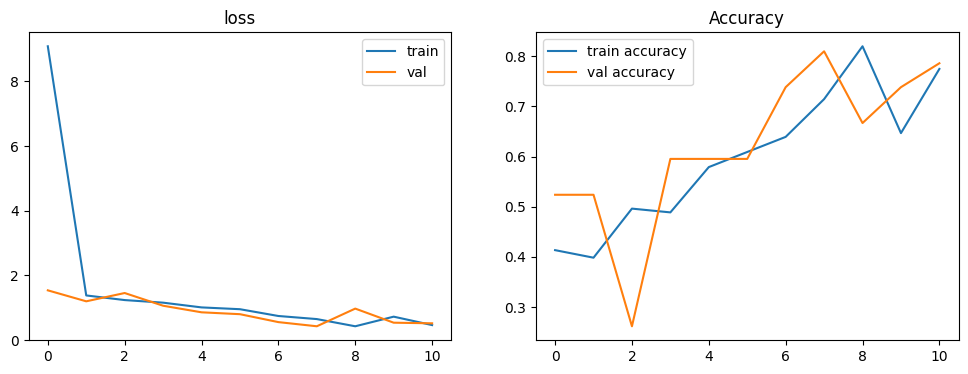

In [85]:
plot_history(history)


In [87]:
# YOUR CODE HERE

y_pred = model.predict(X_test)


# Evaluate accuracy using Keras metrics
accuracy = tf.keras.metrics.CategoricalAccuracy()(y_test, y_pred).numpy()
print("Accuracy on the test set:", accuracy)


2/2 [==============================] - 0s 49ms/step
Accuracy on the test set: 0.8


In [21]:
# define cnn model 1 vgg glock
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
def define_model_1vgg():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(486, 648, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


In [22]:
def define_model_2vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    # opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Epoch 1/10
9/9 [==============================] - 25s 3s/step - loss: 137850549052788178944.0000 - accuracy: 0.2707 - val_loss: 249037962459249606622124292635099136.0000 - val_accuracy: 0.1190
Epoch 2/10
9/9 [==============================] - 16s 2s/step - loss: 27065246486981454620315839593709568.0000 - accuracy: 0.4436 - val_loss: 1.3245 - val_accuracy: 0.5238
Epoch 3/10
9/9 [==============================] - 17s 2s/step - loss: 1.3338 - accuracy: 0.4737 - val_loss: 1.2886 - val_accuracy: 0.5238
Epoch 4/10
9/9 [==============================] - 16s 2s/step - loss: 1.3073 - accuracy: 0.4737 - val_loss: 1.2636 - val_accuracy: 0.5238
Epoch 5/10
9/9 [==============================] - 15s 2s/step - loss: 1.2904 - accuracy: 0.4737 - val_loss: 1.2461 - val_accuracy: 0.5238
Epoch 6/10
9/9 [==============================] - 14s 2s/step - loss: 1.2776 - accuracy: 0.4737 - val_loss: 1.2391 - val_accuracy: 0.5238
Epoch 7/10
9/9 [==============================] - 14s 2s/step - loss: 1.2713 - accu

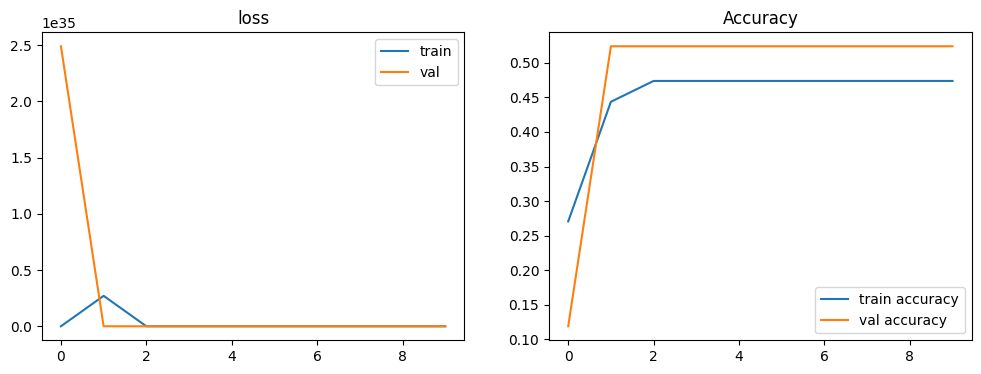

In [43]:
# fit model
vgg_1_model = define_model_1vgg()
history = train_model(vgg_1_model)
plot_history(history)
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))


In [23]:
# fit model
vgg_2_model = define_model_2vgg()
history = train_model(vgg_2_model)
plot_history(history)
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))


Epoch 1/15


: 

In [50]:
def define_model_3vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(486, 648, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Epoch 1/10
9/9 [==============================] - 24s 3s/step - loss: 5.7295 - accuracy: 0.3158 - val_loss: 1.3169 - val_accuracy: 0.5238
Epoch 2/10
9/9 [==============================] - 22s 2s/step - loss: 1.3394 - accuracy: 0.4737 - val_loss: 1.3487 - val_accuracy: 0.5238
Epoch 3/10
9/9 [==============================] - 21s 2s/step - loss: 1.3227 - accuracy: 0.4737 - val_loss: 1.2956 - val_accuracy: 0.5238
Epoch 4/10
9/9 [==============================] - 21s 2s/step - loss: 1.3212 - accuracy: 0.4737 - val_loss: 1.3197 - val_accuracy: 0.5238
Epoch 5/10
9/9 [==============================] - 21s 2s/step - loss: 1.3292 - accuracy: 0.4737 - val_loss: 1.2932 - val_accuracy: 0.5238
Epoch 6/10
9/9 [==============================] - 21s 2s/step - loss: 1.2679 - accuracy: 0.4737 - val_loss: 1.1964 - val_accuracy: 0.5238
Epoch 7/10
9/9 [==============================] - 21s 2s/step - loss: 1.1694 - accuracy: 0.4737 - val_loss: 1.0130 - val_accuracy: 0.5238
Epoch 8/10
9/9 [==================

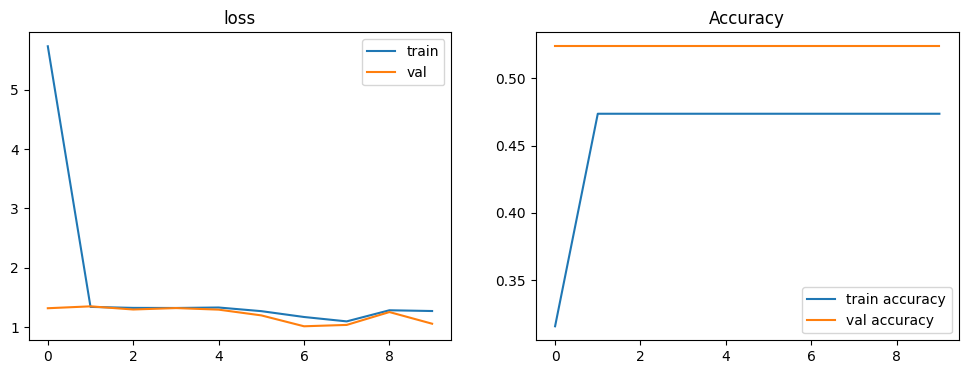

In [51]:
# fit model
vgg_3_model = define_model_3vgg()
history = train_model(vgg_3_model)
plot_history(history)
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))


# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=16)
# fit model
# steps = int(X_train.shape[0] / 16)
history = model.fit_generator( it_train, steps_per_epoch=50, epochs=20, validation_data=(X_val, y_val), verbose=0)

# Train the model
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator,

)

# Plot training history
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()


In [13]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Replace with the actual path to your original images
original_images_dir = '/home/xiao/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/species/Malariae'

# Specify the output directory for augmented images
output_dir = '/home/xiao/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/species/Malariae'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    # rotation_range=20,
    # shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Specify the batch size for generating images
batch_size = 16

# Generate augmented images and save to the output directory
generator = datagen.flow_from_directory(
    original_images_dir,
    target_size=(1944, 2592),
    batch_size=batch_size,
    class_mode=None,  # Set to None since we are not doing classification
    save_to_dir=output_dir,
    save_prefix='augmented',
    save_format='jpg'
)

# Specify the number of augmented images you want to generate
num_augmented_images = 104 - 37

# Generate and save the images
for _ in range(0,4):
    batch = generator.next()

# Note: The above loop generates 'num_augmented_images' images, you can adjust this number based on your needs.


Found 37 images belonging to 1 classes.
